Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from matplotlib import pyplot as plt

Read titanic file and display first 10 records 

In [2]:
titanic = pd.read_csv('titanic.csv')
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Profiling

Display column and row information 

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Search for columns with null values

In [4]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Cleaning
### Fill in null values
Embarked column's null value with the fewest appearing value

In [5]:
embarked_cnt = titanic['Embarked'].value_counts()
least_embarked = embarked_cnt.idxmin(skipna=True)
titanic['Embarked'] = titanic['Embarked'].fillna(least_embarked)
titanic.groupby(['Embarked'])['PassengerId'].count()

Embarked
C    168
Q     79
S    644
Name: PassengerId, dtype: int64

Age column's null value with the median per gender per Fare

In [6]:
##Round off the Fare column in the nearest ones
titanic['Fare'] = titanic.Fare.round(0)

##Create a fare age column where null age is replaced with the median value of gender as per the Fare column
titanic['DummyAge'] = titanic['Age']
titanic['DummyAge'] = titanic.groupby(['Fare', 'Sex'])['DummyAge'].transform(lambda x: x.fillna(x.median()))

##Replace zero values (considered as null) to 1
titanic.DummyAge.fillna(value=1, inplace=True)
titanic['Age']= titanic['DummyAge']
titanic.groupby(['Embarked', 'Sex'])['Age'].count()

Embarked  Sex   
C         female     73
          male       95
Q         female     38
          male       41
S         female    203
          male      441
Name: Age, dtype: int64

### Create age group column 

In [7]:
##Create age groups
age_labels = ['Young 0-20', 'Adult 21-40', 'Middle Age 41-60', 'Senior 61-80']
titanic['AgeGroup'] = pd.cut(titanic.Age, range(0, 81, 20), labels=age_labels)
titanic.groupby(['AgeGroup', 'Sex'])['Age'].count()

AgeGroup          Sex   
Young 0-20        female     91
                  male      113
Adult 21-40       female    173
                  male      356
Middle Age 41-60  female     47
                  male       88
Senior 61-80      female      3
                  male       20
Name: Age, dtype: int64

### Create family column 

In [8]:
titanic['Family']=titanic.apply(lambda row: 1 if(row.SibSp+row.Parch)>0 else 0, axis=1)
titanic.groupby(['Sex', 'Survived'])['Family'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Family, dtype: int64

### Drop dummy age and cabin columns

In [9]:
#Dropping the columns not required for Analysis
titanic = titanic.drop(columns=['DummyAge','Cabin'])
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
AgeGroup       891 non-null category
Family         891 non-null int64
dtypes: category(1), float64(2), int64(6), object(4)
memory usage: 84.7+ KB


## Analysis
Get the following total number of information:
- passengers
- survivors

In [10]:
print('Passengers : ', len(titanic))
print('Survivors  : ', len(titanic[titanic["Survived"] == 1])," = %.2f" % (100 * np.mean(titanic["Survived"])),'%')

Passengers :  891
Survivors  :  342  = 38.38 %


### Passengers who have survived/deceased by gender

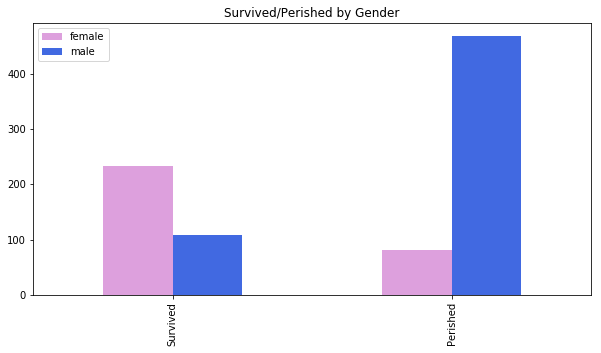

In [11]:
survived_sex = titanic[titanic['Survived']==1]['Sex'].value_counts()
deceased_sex = titanic[titanic['Survived']==0]['Sex'].value_counts()
data1 = pd.DataFrame([survived_sex,deceased_sex])
data1.index = ['Survived','Perished']
data1.plot(kind='bar',figsize=(10,5), color=['plum','royalblue'], title='Survived/Perished by Gender')

### Passengers who have survived/deceased by passenger class

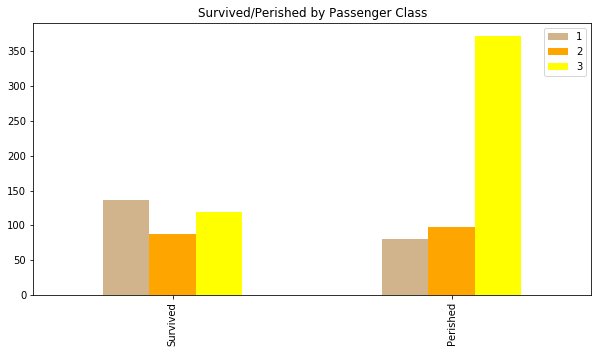

In [12]:
survived_class = titanic[titanic['Survived']==1]['Pclass'].value_counts()
deceased_class = titanic[titanic['Survived']==0]['Pclass'].value_counts()
data2 = pd.DataFrame([survived_class,deceased_class])
data2.index = ['Survived','Perished']
data2.plot(kind='bar', figsize=(10,5), color=['tan','orange','yellow'], title='Survived/Perished by Passenger Class')

### Passengers who have survived/deceased by embarkation point

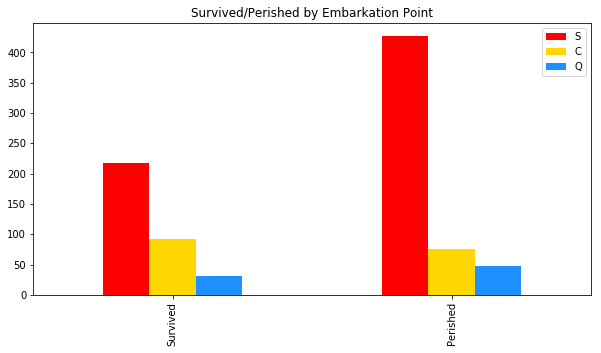

In [13]:
survived_embarked = titanic[titanic['Survived']==1]['Embarked'].value_counts()
deceased_embarked = titanic[titanic['Survived']==0]['Embarked'].value_counts()
data3 = pd.DataFrame([survived_embarked,deceased_embarked])
data3.index = ['Survived','Perished']
data3.plot(kind='bar', figsize=(10,5), color=['red','gold','dodgerblue'], title='Survived/Perished by Embarkation Point')
#'Southampton','Cherbourg','Queenstown'

### Passengers who have survived/deceased by age group

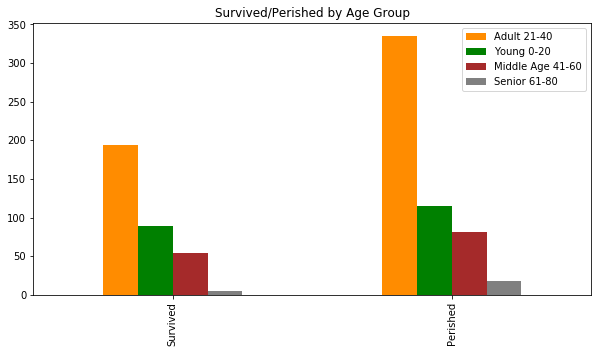

In [14]:
survived_agegroup = titanic[titanic['Survived']==1]['AgeGroup'].value_counts()
deceased_agegroup = titanic[titanic['Survived']==0]['AgeGroup'].value_counts()
data3 = pd.DataFrame([survived_agegroup,deceased_agegroup])
data3.index = ['Survived','Perished']
data3.plot(kind='bar', figsize=(10,5), color=['darkorange','green','brown','gray'], title='Survived/Perished by Age Group')

### Passengers who have survived/deceased with/without family

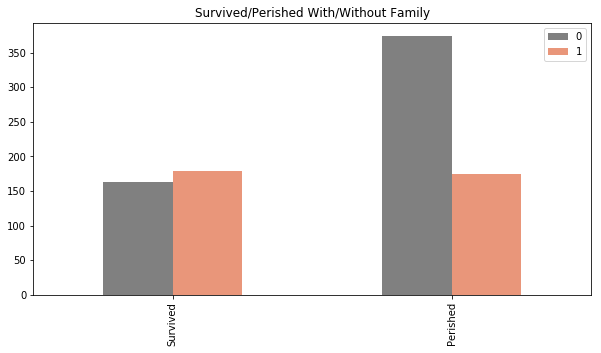

In [15]:
survived_family = titanic[titanic['Survived']==1]['Family'].value_counts()
deceased_family = titanic[titanic['Survived']==0]['Family'].value_counts()
data1 = pd.DataFrame([survived_family,deceased_family])
data1.index = ['Survived','Perished']
data1.plot(kind='bar',figsize=(10,5), color=['gray','darksalmon'], title='Survived/Perished With/Without Family')

### Passenger survival distribution by age and fare

Text(0.5,0,'Fare')

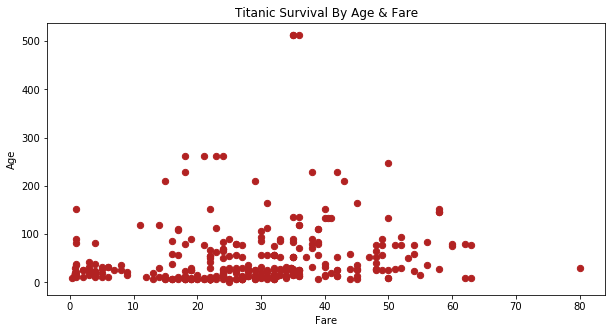

In [16]:
plt.figure(figsize=(10,5))
plt.title('Titanic Survival By Age & Fare')
plt.scatter(titanic[titanic['Survived']==1]['Age'],titanic[titanic['Survived']==1]['Fare'],c='firebrick',s=40)
plt.ylabel('Age')
plt.xlabel('Fare')

### Passenger survival distribution by age, fare, and travelling with/without family

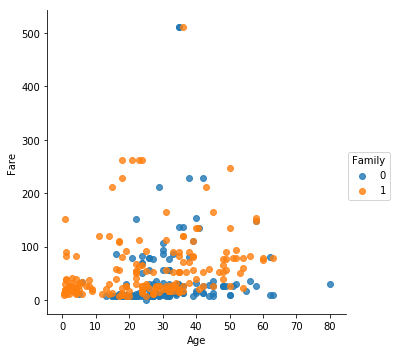

In [17]:
survivors = titanic.loc[:,['Family', 'Age', 'Fare', 'Survived']][titanic.Survived == 1].sort_values('Fare', ascending=False)
sns.lmplot(x='Age', y='Fare',hue='Family', data=survivors, fit_reg = False)

## Conclusion

Out of the 891 passengers who boarded the Titanic, only 342 (38%) survived.

Gender - There were more male passengers than female passengers who boarded the Titanic but there were more females who survived.

Passenger Class - Majority of the passengers came from Class 3 and almost the same number with Classes 2 and 1. However, there are more survivors in Class 1 than Class 3.  It is worth of note that a lot of passengers in Class 2 survived.

Embarkation Point - Majority of passengers embarked in Southampton, second in Cherbourg, and the least in Queenstown.
On embarkation point, the same sequence of survival follows.

Age Group - Majority of passengers are in the age group between 21-40, second are the young (ages 0-20), third are those in middle age (41-60), and the least are senior citizens.  The same with embarkation point, the sequence on survival follows.

Travelling with Family - A big percentage of those who boarded the Titanic are without family members but majority of survivors have family members travelling with them.
